In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import math
import time
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Splitting, tokenizing and Embedding

In [ ]:
sentence = 'I want to know if you can understand this text or not'
word2id = {w: i for i,w in enumerate(set(sentence.split()))}
word2id

{'or': 0,
 'can': 1,
 'not': 2,
 'I': 3,
 'want': 4,
 'this': 5,
 'you': 6,
 'to': 7,
 'understand': 8,
 'if': 9,
 'text': 10,
 'know': 11}

In [ ]:
input_ids = torch.tensor([word2id[w] for w in sentence.split()])
input_ids

tensor([ 3,  4,  7, 11,  9,  6,  1,  8,  5, 10,  0,  2])

In [ ]:
embeded_layer = nn.Embedding(max(input_ids)+1, 16)
word_embedings = embeded_layer(input_ids)
word_embedings

tensor([[-2.9432e-01, -9.4133e-01,  1.9138e-01, -1.5908e-03, -2.4915e-01,
          6.1004e-02,  1.8377e+00, -5.6522e-01, -1.6325e-01, -7.9248e-01,
         -2.3893e-01,  1.6901e-01, -2.7587e-01,  1.5362e-01, -7.7754e-01,
         -1.3021e-01],
        [ 2.0531e-01, -5.9821e-01, -1.1826e+00,  1.1362e+00,  1.6768e+00,
         -1.2552e+00, -8.8543e-01, -1.2147e+00,  1.5999e+00, -2.3164e+00,
         -1.8000e-01,  1.2280e+00,  1.3015e+00,  2.7681e-01,  5.4153e-01,
         -1.5005e+00],
        [-1.2064e+00, -3.9154e-01,  7.0269e-01,  1.5339e+00, -9.4244e-02,
         -4.4524e-01, -2.9941e-01,  1.0146e+00, -2.0111e+00,  1.9601e-01,
          1.5265e+00, -3.9958e-01,  1.2791e-01,  1.2841e+00,  5.0105e-01,
          5.6788e-01],
        [-7.3494e-01, -8.6939e-01, -1.5024e+00,  1.1369e+00, -5.7125e-01,
          2.8591e-01, -6.1904e-01,  9.3585e-01, -5.5575e-01, -1.3841e+00,
         -7.8577e-01, -1.3095e-01,  4.9475e-01, -1.1216e+00,  2.9224e-01,
         -3.7327e-01],
        [-1.8605e-01

In [ ]:
def get_positional_encoding(max_seq_len, d):
    position = np.arange(max_seq_len)[:, np.newaxis]
    div_term = np.exp(np.arange(0, d, 2) * -(math.log(10000.0) / d))
    positional_enc = np.zeros((max_seq_len, d))
    positional_enc[:, 0::2] = np.sin(position * div_term)
    positional_enc[:, 1::2] = np.cos(position * div_term)
    return torch.tensor(positional_enc, dtype=torch.float)

In [ ]:
def plot_heatmap(data):
    plt.figure(figsize=(7,7))
    sns.heatmap(data, cmap='cool', vmin=-1, vmax=1)
    plt.xlabel('Embedding Dimensions')
    plt.ylabel('Word')
    plt.title('Positional Encodeing')
    plt.show()

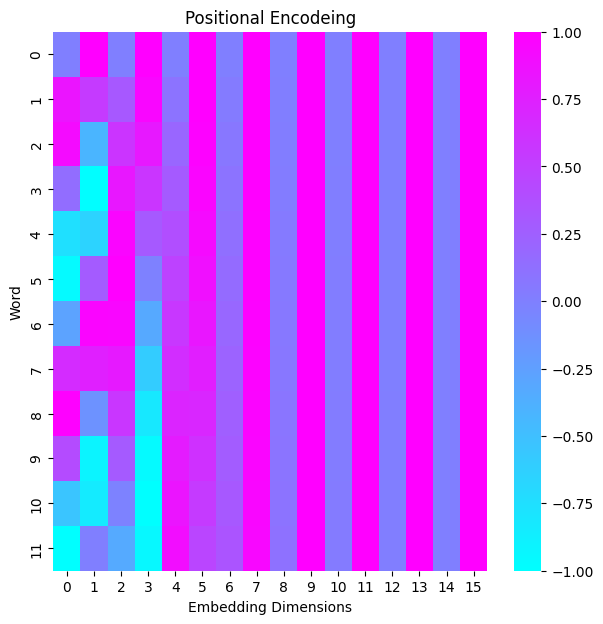

In [ ]:
max_seq_len = len(sentence.split())
d = 16
positional_encodeings = get_positional_encoding(max_seq_len, d)
plot_heatmap(positional_encodeings)

In [ ]:
class DecoderBlock(nn.Module):
    def __init__(self, d, num_heads, ff_hidden_dim, dropout=0.1):
        super().__init__()

        self.self_attention = nn.MultiheadAttention(d, num_heads, dropout=dropout)
        self.norm1 = nn.LayerNorm(d)
        self.dropout1 = nn.Dropout(dropout)
        self.linear1 = nn.Linear(d, ff_hidden_dim)
        self.linear2 = nn.Linear(ff_hidden_dim, d)
        self.norm2 = nn.LayerNorm(d)
        self.dropout2 = nn.Dropout(dropout)

    def forward(self, x, mask):
      attn_out, _ = self.self_attention(x, x, x, attn_mask=mask)
      x = x + self.dropout1(attn_out)
      x = self.norm1(x)
      ff_out = self.linear2(F.relu(self.linear1(x)))
      x = x + self.dropout2(ff_out)
      x = self.norm2(x)
      return x

In [ ]:
class PositionalEncoding(nn.Module):
    def __init__(self, d, dropout=0.1, max_len=5000):
        super(PositionalEncoding, self).__init__()
        self.dropout = nn.Dropout(dropout)

        pe = torch.zeros(max_len, d)
        position = torch.arange(0, max_len, dtype=torch.float).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, d, 2).float() * (-math.log(10000.0) / d))
        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)
        pe = pe.unsqueeze(0).transpose(0, 1)
        self.register_buffer('pe', pe)

    def forward(self, x):
        x = x + self.pe[:x.size(0), :]
        return self.dropout(x)


In [ ]:
class TransformerDecoder(nn.Module):
    def __init__(self, vocab_size, d, num_heads, ff_hidden_dim, dropout=0.1):
        super(TransformerDecoder, self).__init__()

        self.embedding = nn.Embedding(vocab_size, d)
        self.pos_encoder = PositionalEncoding(d, dropout)
        self.transformer_block = DecoderBlock(d, num_heads, ff_hidden_dim, dropout)
        self.linear = nn.Linear(d, vocab_size)
        self.softmax = nn.LogSoftmax(dim=1)

    def forward(self, x):
        x = self.embedding(x)
        x = self.pos_encoder(x)
        mask = generate_square_subsequent_mask(x.size(0))
        x = self.transformer_block(x, mask)
        x = self.linear(x)
        x = self.softmax(x)
        return x



/usr/local/lib/python3.10/dist-packages/matplotlib/colors.py:1354: RuntimeWarning: invalid value encountered in subtract
  resdat -= vmin
/usr/local/lib/python3.10/dist-packages/matplotlib/colors.py:1355: RuntimeWarning: invalid value encountered in divide
  resdat /= (vmax - vmin)


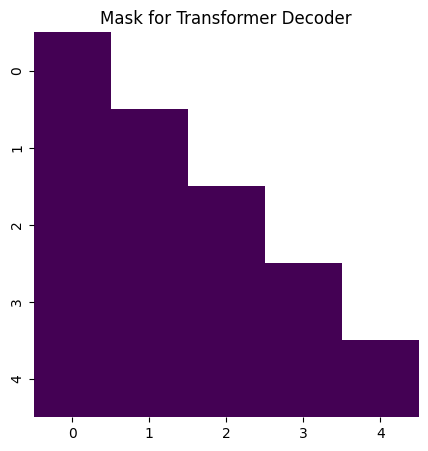

In [ ]:
def generate_square_subsequent_mask(sz):
    mask = (torch.triu(torch.ones(sz, sz)) == 1).transpose(0,1)
    mask = mask.float().masked_fill(mask == 0, float('-inf')).masked_fill(mask == 1, float(0.0))
    return mask

mask = generate_square_subsequent_mask(5)

plt.figure(figsize=(5,5))
sns.heatmap(mask, cmap='viridis', cbar=False, square=True)
plt.title('Mask for Transformer Decoder')
plt.show()

# Decoder

In [ ]:
#hyperparameters
vocab_size = 1000
d = 512
num_heads = 1
ff_hidden_dim = 2+d
dropout = 0.1
num_layers = 10
context_length = 50
batch_size = 1

model = TransformerDecoder(vocab_size, d, num_heads, ff_hidden_dim, dropout)

input_tensor = torch.randint(0, vocab_size, (batch_size, context_length))

output = model(input_tensor)

print(output.shape)

predicted_indices = torch.argmax(output, dim=-1)

print(predicted_indices.shape)

torch.Size([1, 50, 1000])
torch.Size([1, 50])


In [ ]:
# how many parameters
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

print('Model parameters:', count_parameters( model))

Model parameters: 2605034


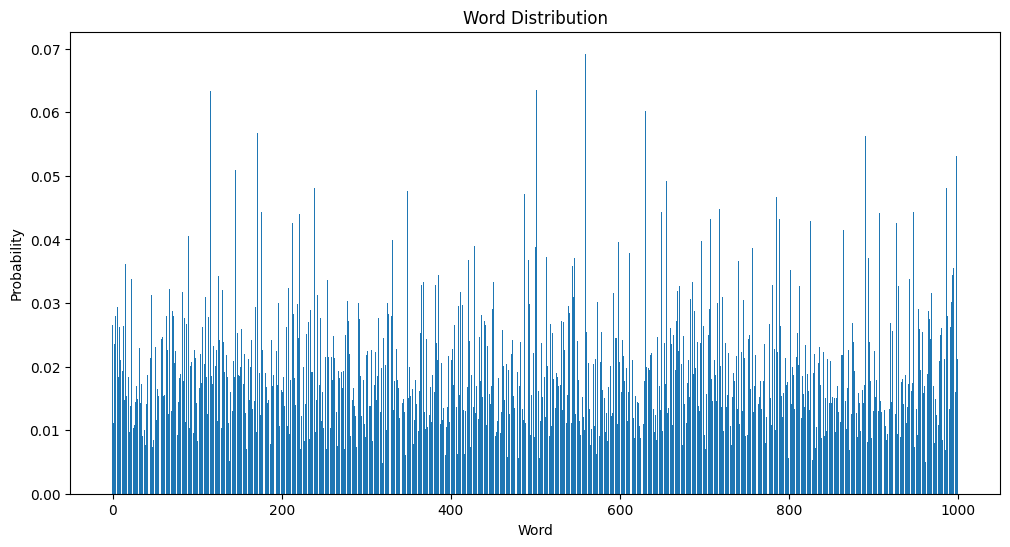

In [ ]:
distribution = torch.exp(output[0, 0, :])
distribution = distribution.detach().numpy()

plt.figure(figsize=(12, 6))
plt.bar(np.arange(vocab_size), distribution)
plt.xlabel('Word')
plt.ylabel('Probability')
plt.title('Word Distribution')
plt.show()

## Multi-Layer

In [ ]:
class MultiLayerTransformerDecoder(nn.Module):
    def __init__(self, vocab_size, d, num_heads, ff_hidden_dim, dropout=0.1, num_layers=10):
        super(MultiLayerTransformerDecoder, self).__init__()

        self.embedding = nn.Embedding(vocab_size, d)
        self.pos_encoder = PositionalEncoding(d, dropout)
        self.transformer_layers = nn.ModuleList([
            DecoderBlock(d, num_heads, ff_hidden_dim, dropout) for _ in range(num_layers)
        ])
        self.linear = nn.Linear(d, vocab_size)
        self.softmax = nn.LogSoftmax(dim=1)

    def forward(self, x):
      x = self.embedding(x)
      x = self.pos_encoder(x)
      mask = generate_square_subsequent_mask(x.size(0))
      for layer in self.transformer_layers:
          mask = generate_square_subsequent_mask(x.size(0))
          x = layer(x, mask)
      x = self.linear(x)
      x = self.softmax(x)
      return x


In [ ]:
#hyperparameters
vocab_size = 1000
d = 2048
num_heads = 1
ff_hidden_dim = 4+d
dropout = 0.1
num_layers = 10
context_length = 100
batch_size = 1

input_tensor = torch.randint(0, vocab_size, (batch_size, context_length))

model = MultiLayerTransformerDecoder(vocab_size, d, num_heads, ff_hidden_dim, dropout, num_layers)

output = model(input_tensor)

print(output.shape)

torch.Size([1, 100, 1000])


In [ ]:
# how many parameters
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

print('Model parameters:', count_parameters( model))

Model parameters: 256123920


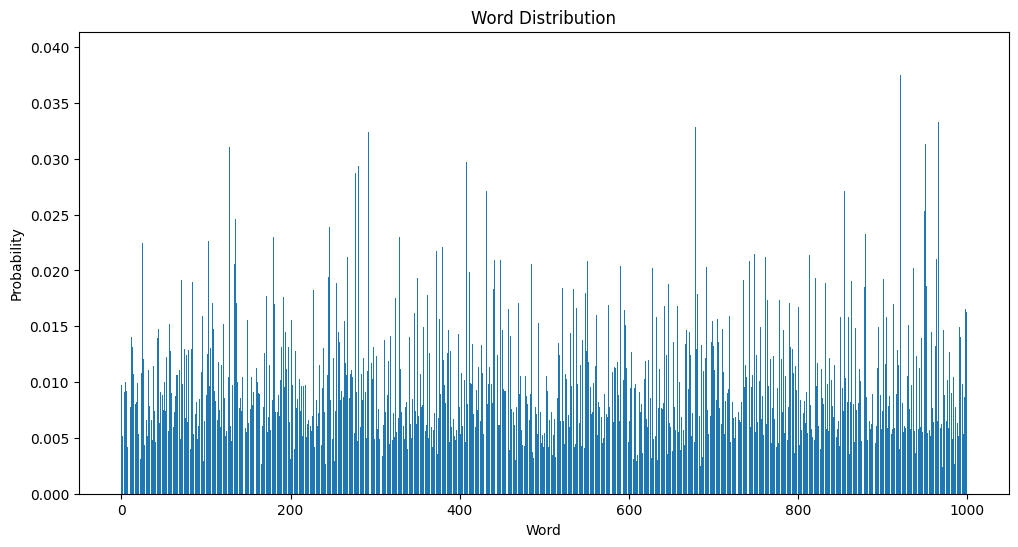

In [ ]:
distribution = torch.exp(output[0, 0, :])
distribution = distribution.detach().numpy()

plt.figure(figsize=(12, 6))
plt.bar(np.arange(vocab_size), distribution)
plt.xlabel('Word')
plt.ylabel('Probability')
plt.title('Word Distribution')
plt.show()

In [57]:
# model info
model

MultiLayerTransformerDecoder(
  (embedding): Embedding(1000, 2048)
  (pos_encoder): PositionalEncoding(
    (dropout): Dropout(p=0.1, inplace=False)
  )
  (transformer_layers): ModuleList(
    (0-9): 10 x DecoderBlock(
      (self_attention): MultiheadAttention(
        (out_proj): NonDynamicallyQuantizableLinear(in_features=2048, out_features=2048, bias=True)
      )
      (norm1): LayerNorm((2048,), eps=1e-05, elementwise_affine=True)
      (dropout1): Dropout(p=0.1, inplace=False)
      (linear1): Linear(in_features=2048, out_features=2052, bias=True)
      (linear2): Linear(in_features=2052, out_features=2048, bias=True)
      (norm2): LayerNorm((2048,), eps=1e-05, elementwise_affine=True)
      (dropout2): Dropout(p=0.1, inplace=False)
    )
  )
  (linear): Linear(in_features=2048, out_features=1000, bias=True)
  (softmax): LogSoftmax(dim=1)
)

# Adding vocab

In [59]:
#hyperparameters
vocab = ['me', 'you', 'black', 'I', 'how', 'think', 'fox', 'now', 'don`t', 'know', 'leg']
d = 2048
num_heads = 1
ff_hidden_dim = 4+d
dropout = 0.1
num_layers = 10
context_length = 5
batch_size = 1
vocab_size = len(vocab)

word2id = {w: i for i,w in enumerate(vocab)}
id2word = {i: w for i,w in enumerate(vocab)}

model = MultiLayerTransformerDecoder(vocab_size, d, num_heads, ff_hidden_dim, dropout, num_layers)
sequence = ['me', 'you', 'black', 'I', 'how', 'think', 'fox', 'now'][:context_length]
input_tensor = torch.tensor([word2id[w] for w in sequence])

generated_words = []
for i in range(10):
    output = model(input_tensor.unsqueeze(0))
    predicted_index = torch.argmax(output[0, -1, :]).item()
    generated_words.append(id2word[predicted_index])
    input_tensor = torch.cat([input_tensor, torch.tensor([predicted_index])])

print(generated_words)

['think', 'you', 'I', 'don`t', 'don`t', 'fox', 'know', 'you', 'I', 'don`t']


# Using GPT2

In [60]:
from transformers import GPT2Tokenizer, GPT2LMHeadModel

tokenizer = GPT2Tokenizer.from_pretrained('gpt2')
model = GPT2LMHeadModel.from_pretrained('gpt2')

tokenizer_config.json:   0%|          | 0.00/26.0 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/1.04M [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

config.json:   0%|          | 0.00/665 [00:00<?, ?B/s]

/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


model.safetensors:   0%|          | 0.00/548M [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/124 [00:00<?, ?B/s]

In [61]:
prompt = 'I`m trying to learn more things about LLM and how'

In [65]:
from transformers import GPT2Tokenizer, GPT2LMHeadModel

tokenizer = GPT2Tokenizer.from_pretrained('gpt2')
model = GPT2LMHeadModel.from_pretrained('gpt2')

prompt = 'I`m trying to learn more things about LLM and how'
input = tokenizer.encode(prompt, return_tensors='pt')

attention_mask = torch.ones(input.shape, dtype=torch.long)

pad_token_id = tokenizer.eos_token_id

print(prompt, end=' ', flush=True)

for _ in range(25):
    position_ids = torch.arange(input.shape[-1], dtype=torch.long, device=input.device).unsqueeze(0)

    output = model.generate(input, max_length=input.shape[-1]+1, do_sample=True, pad_token_id=pad_token_id, attention_mask=attention_mask, position_ids=position_ids)

    gen_words = tokenizer.decode(output[0][-1])
    print(gen_words, end=' ', flush=True)
    input = torch.cat([input, output[:, -1:]], dim=-1)

I`m trying to learn more things about LLM and how  to  build  it ;  hopefully  the  next  two  weeks  will  introduce  you  to  all  the  possibilities . 
 
 In  this  interview ,  I 'd 